概率数据结构允许在内存使用量大幅减少的情况下，在准确性方面进行权衡。此外，可以对它们执行的操作的数量比使用set或trie限制得多。例如，对于一个使用2.56kb的HyperLogLog++结构，可以计算最多约7900000000项的唯一项数，错误率为1.625%。

这意味着，如果试图计算汽车的唯一车牌号，并且我们的HyperLogLog++计数器显示有654192028个，那么我们有信心实际的车牌号在643561407到664822648之间。此外，如果这种精度不够，可以简单地向结构中添加更多内存，它的性能会更好。给它40.96kb的资源将把错误从1.625%减少到0.4%。然而，在一个集合中存储这些数据需要3.925 GB，即使假设没有开销！

另一方面，HyperLogLog++结构只能计算一组车牌并与另一组车牌合并。例如，可以为每个省设置一个结构，找出每个省有多少个独特的车牌，然后将它们合并，得到整个国家的车牌数。如果给我们一个车牌，我们不能很准确地告诉你我们以前是否见过，也不能给你一个我们已经见过的车牌样本。

当花时间去理解这个问题，并且需要把一些东西投入生产，这些东西可以回答关于一个非常大的数据集的一个非常小的问题时，概率数据结构是非常棒的。每个结构都有不同的问题，它可以以不同的精度回答，因此找到正确的问题只是理解您的需求的问题。

In [5]:
! pip install countmemaybe

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/


几乎在所有情况下，概率数据结构都是通过为数据寻找一种更紧凑的替代表示来工作的，它包含了回答某一组问题的相关信息。这可以看作是一种有损压缩，我们可能会丢失某些方面的数据，但我们保留了必要的组件。由于我们允许丢失与我们关心的特定问题不一定相关的数据，这种有损压缩可能比我们以前尝试过的无损压缩更有效。正因为如此，您将使用哪个概率数据结构的选择是非常重要的—您希望选择一个为您的用例保留正确信息的结构！

在我们深入讨论之前，应该弄清楚，这里所有的“错误率”都是用标准差来定义的。这个术语来自于描述高斯分布，并表示函数是如何围绕中心值展开的。当标准差增大时，远离中心点的值的数目也会增大。概率数据结构的错误率是这样定义的，因为它们周围的所有分析都是概率的。例如，当我们说HyperLogLog++算法有一个错误时，我们的意思是68%的时间误差小于err，95%的时间误差小于2× 错误，99.7%的时间它会小于3× 错误

## 用1字节Morris计数器进行非常近似的计数

我们将用最早的概率计数器Morris计数器（由NSA和贝尔实验室的Robert Morris）介绍概率计数的主题。应用包括在受限的RAM环境中（例如，在嵌入式计算机上）计算数以百万计的对象，理解大型数据流，以及处理像图像和语音识别这样的人工智能问题。

Morris计数器跟踪指数并将计数状态建模为（而不是正确的计数）-它提供了一个数量级估计。使用概率规则更新此估计。

我们从指数设为0开始。如果我们问计数器的值，我们会得到pow（2，exponent）=1（敏锐的读者会注意到，这是一个关闭的值，我们说这是一个近似的计数器！）。如果我们要求计数器自身递增，它将生成一个随机数（使用均匀分布），并测试random.uniform（0，1）<=1/pow（2，exponent），它将始终为真（pow（2，0）==1）。计数器递增，指数设置为1。

第二次我们要求计数器自身递增，它将测试random.uniform（0，1）<=1/pow（2，1）。50%的时候都是这样。如果测试通过，则指数递增。如果不是，则不会为此增量请求增加指数。

下表显示了每个第一指数出现增量的可能性。

表：Morris计数详情

<table id="table_morris_counter">
<caption><span class="label">Table 11-1. </span>Morris counter details</caption>
<thead>
<tr>
<th>Exponent</th>
<th>pow(2,<em>exponent</em>)</th>
<th>P(<em>increment</em>)</th>
</tr>
</thead>
<tbody>
<tr>
<td><p>0</p></td>
<td><p>1</p></td>
<td><p>1</p></td>
</tr>
<tr>
<td><p>1</p></td>
<td><p>2</p></td>
<td><p>0.5</p></td>
</tr>
<tr>
<td><p>2</p></td>
<td><p>4</p></td>
<td><p>0.25</p></td>
</tr>
<tr>
<td><p>3</p></td>
<td><p>8</p></td>
<td><p>0.125</p></td>
</tr>
<tr>
<td><p>4</p></td>
<td><p>16</p></td>
<td><p>0.0625</p></td>
</tr>
<tr>
<td><p>…</p></td>
<td><p>…</p></td>
<td><p>…</p></td>
</tr>
<tr>
<td><p>254</p></td>
<td><p>2.894802e+76</p></td>
<td><p>3.454467e-77</p></td>
</tr>
</tbody>
</table>

当我们使用一个无符号字节作为指数时，我们可以近似计算的最大值是math.pow（2255）==5e76。随着计数的增加，相对于实际计数的错误将相当大，但是RAM节省是巨大的，因为我们只使用1字节，而不是我们必须使用的32个无符号字节。下面例子展示了Morris计数器的简单实现。

例：简单的Morris计数器实现

In [40]:
"""Approximate Morris counter supporting many counters"""
import math
import random
import array

SMALLEST_UNSIGNED_INTEGER = 'B' # unsigned char, typically 1 byte


class MorrisCounter(object):
    """Approximate counter, stores exponent and counts approximately 2^exponent

    https://en.wikipedia.org/wiki/Approximate_counting_algorithm"""
    def __init__(self, type_code=SMALLEST_UNSIGNED_INTEGER, nbr_counters=1):
        self.exponents = array.array(type_code, [0] * nbr_counters)

    def __len__(self):
        return len(self.exponents)

    def add_counter(self):
        """Add a new zeroed counter"""
        self.exponents.append(0)

    def get(self, counter=0):
        """Calculate approximate value represented by counter"""
        return math.pow(2, self.exponents[counter])

    def add(self, counter=0):
        """Probabilistically add 1 to counter"""
        value = self.get(counter)
        probability = 1.0 / value
        if random.uniform(0, 1) < probability:
            self.exponents[counter] += 1

if __name__ == "__main__":
    mc = MorrisCounter()
    print("MorrisCounter has {} counters".format(len(mc)))
    for n in range(10):
        print("Iteration %d, MorrisCounter has: %d" % (n, mc.get()))
        mc.add()

    for n in range(990):
        mc.add()
    print("Iteration 1000, MorrisCounter has: %d" % (mc.get()))

MorrisCounter has 1 counters
Iteration 0, MorrisCounter has: 1
Iteration 1, MorrisCounter has: 2
Iteration 2, MorrisCounter has: 4
Iteration 3, MorrisCounter has: 8
Iteration 4, MorrisCounter has: 8
Iteration 5, MorrisCounter has: 8
Iteration 6, MorrisCounter has: 8
Iteration 7, MorrisCounter has: 8
Iteration 8, MorrisCounter has: 8
Iteration 9, MorrisCounter has: 8
Iteration 1000, MorrisCounter has: 1024


使用这个实现，我们可以在下面示例中看到第一个增加计数器的请求成功，第二个成功，第三个不成功。

例：Morris计数器库示例

In [41]:
mc = MorrisCounter()

In [42]:
mc.get()

1.0

In [43]:
mc.add()

In [44]:
mc.get()

2.0

In [45]:
mc.add()

In [46]:
mc.get()

4.0

In [47]:
mc.add()

In [48]:
mc.get()

4.0

在下面图中，粗黑线表示在每次迭代中递增的正整数。在64位计算机上，这是一个8字节的整数。三个1字节Morris计数器的演变如虚线所示；y轴显示它们的值，这些值大致表示每个迭代的真实计数。显示了三个计数器，让您了解它们的不同轨迹和总体趋势；这三个计数器彼此完全独立。

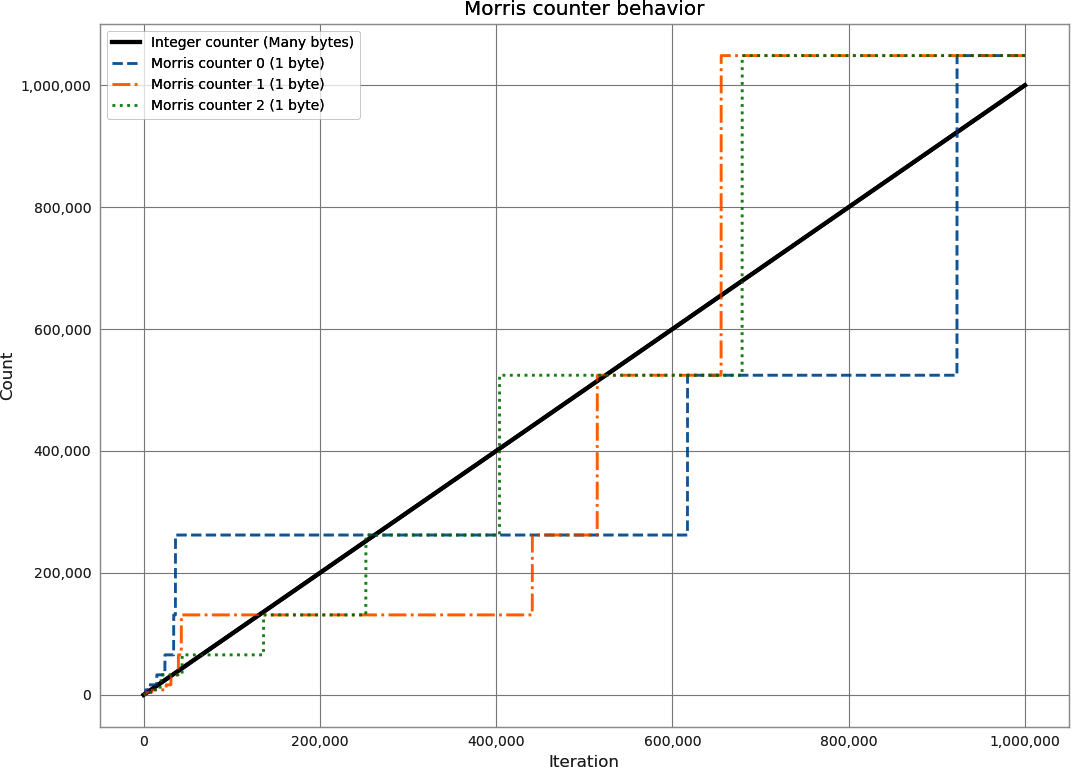

三个1字节Morris计数器与一个8字节整数

此图提供了一些有关使用Morris计数器时预期错误的信息。有关错误行为的更多详细信息，请在线查看。

## K-最小值

在莫里斯柜台，我们丢失了所有关于我们所插入物品的信息。也就是说，无论我们使用.add（“micha”）还是.add（“ian”），计数器的内部状态都是相同的。这些额外的信息是有用的，如果使用得当，可以帮助我们让我们的计数器只计算独特的项目。这样，调用.add（“micha”）数千次只会增加计数器一次。

为了实现这种行为，我们将利用哈希函数的属性（有关哈希函数的更深入讨论，请参阅“哈希函数和熵”）。我们想利用的主要特性是散列函数接受输入并将其均匀分布。例如，假设我们有一个哈希函数，它接收一个字符串并输出一个介于0和1之间的数字。如果该函数是统一的，则意味着当我们将其输入字符串时，我们同样可能得到0.5的值作为0.2的值或任何其他值。这也意味着，如果我们将它输入许多字符串值，我们会期望这些值的间隔相对均匀。记住，这是一个概率论证：值的间隔并不总是均匀的，但是如果我们有很多字符串，并且多次尝试这个实验，它们的间隔往往是均匀的。
假设我们取了100个项目并存储了这些值的散列（散列是从0到1的数字）。知道间距甚至意味着，我们不需要说“我们有100个项目”，我们可以说，“每个项目之间的距离为0.01。”这就是K最小值算法最终在4中出现的地方——如果我们保持我们看到的K最小唯一散列值，我们可以近似计算散列值之间的总间距，并推断出项目的总数。在图中 11-8，随着越来越多的项目被添加，我们可以看到K-最小值结构（也称为KMV）的状态。首先，由于我们没有太多散列值，所以我们保留的最大散列值非常大。随着我们添加的越来越多，我们保存的k散列值中的最大值变得越来越小。利用这种方法，我们可以得到的错误率。

k越大，我们就越能说明我们正在使用的哈希函数对于我们的特定输入和不幸的哈希值不是完全一致的。不幸的散列值的一个例子是散列['A'、'B'、'C']并获得值[0.01、0.02、0.03]。如果我们开始散列越来越多的值，它们聚集的可能性就越来越小。

此外，由于我们只保留最小的唯一散列值，因此数据结构只考虑唯一的输入。我们可以很容易地看到这一点，因为如果我们处于只存储最小的三个哈希值的状态，并且当前[0.1，0.2，0.3]是最小的哈希值，那么如果我们添加哈希值为0.4的内容，我们的状态也不会改变。类似地，如果我们添加更多散列值为0.3的项，我们的状态也不会改变。这是一个称为幂等的性质；这意味着，如果我们用相同的输入对这个结构多次执行相同的操作，状态就不会改变。例如，这与附加在列表上形成对比，附加总是会更改其值。除Morris计数器外，幂等性的概念还适用于本节中的所有数据结构。

下面例子显示了一个非常基本的K-最小值实现。值得注意的是我们使用了sortedset，它和set一样，只能包含唯一的项。这种唯一性免费提供了我们的结构幂等性。要了解这一点，请按照代码执行：当同一项被多次添加时，data属性不会更改。

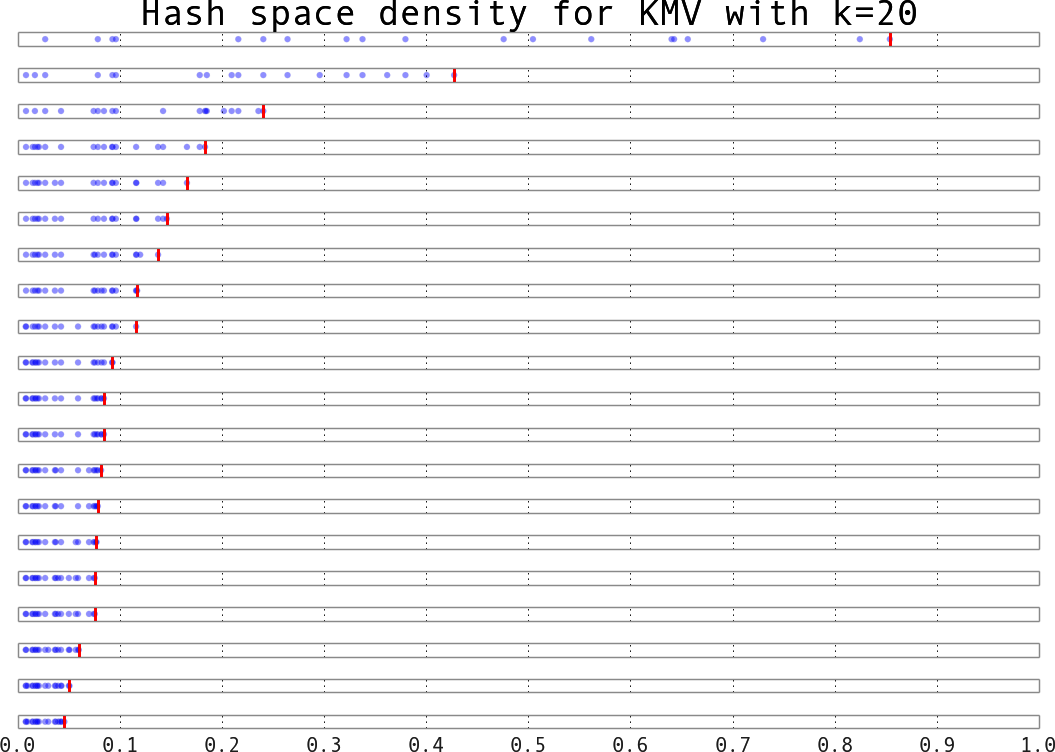

In [6]:
! pip install mmh3

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/


added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
added
adde

D:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


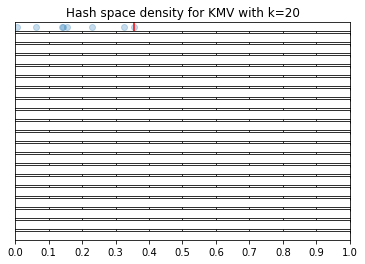

In [1]:
import os
import sys

import pylab as py
from probabilistic_datastructures.kminvalues import KMinValues

sys.path.append(os.path.abspath("./probabilistic_datastructures/"))

def plot(kmv):
    py.scatter(
        [d / float(2 ** 32 - 1) for d in kmv.data[:-1]],
        [0] * (len(kmv.data) - 1),
        alpha=0.25,
    )
    py.axvline(x=(kmv.data[-2] / float(2 ** 32 - 1)), c="r")
    py.gca().get_yaxis().set_visible(False)
    py.gca().get_xaxis().set_ticklabels([])
    py.gca().get_xaxis().set_ticks([x / 10.0 for x in range(11)])


if __name__ == "__main__":
    k = 20
    num_panels = 20
    kmv = KMinValues(k)
    for i in range(k * num_panels + 1):
        if i % k == 0 and i != 0:
            py.subplot(num_panels, 1, i // k)
            if i == k:
                py.title("Hash space density for KMV with k=%d" % k)
            plot(kmv)
            py.xlim((0, 1))
        kmv.add(str(i))
        print("added")

    py.gca().get_xaxis().set_ticks([x / 10.0 for x in range(11)])
    py.gca().get_xaxis().set_ticklabels([x / 10.0 for x in range(11)])

    py.tight_layout()
    py.savefig("kmv.png")


例：简单的KMUES实现

例：countmemaybe KMinValues实现

In [ ]:
kmv1 = KMinValues(k=1024)

In [ ]:
kmv2 = KMinValues(k=1024)

In [ ]:
for i in range(0,50000):  #我们在kmv1中加入了50000个元素。
    kmv1.add(str(i))
   ...:

In [ ]:
for i in range(25000, 75000): #kmv2还获得50000个元素，其中25000个元素也在kmv1中。
    kmv2.add(str(i))
   ...:

In [ ]:
print(len(kmv1))

In [ ]:
print(len(kmv2))

In [ ]:
print(kmv1.cardinality_intersection(kmv2))

In [ ]:
print(kmv1.cardinality_union(kmv2))

注意
在这些算法中，哈希函数的选择对估计的质量有很大的影响。这两个实现都使用mmh3，mmh3是hash3的一个Python实现，对于散列字符串有很好的属性。但是，如果对特定的数据集更方便，可以使用不同的哈希函数。

## Bloom过滤器

有时我们需要能够进行其他类型的集合运算，为此我们需要引入新类型的概率数据结构。Bloom过滤器的诞生是为了回答我们以前是否见过这样一个问题
Bloom过滤器通过具有多个散列值来工作，以便将一个值表示为多个整数。如果我们后来看到某个东西具有相同的整数集，我们可以有理由相信它是相同的值。

为了有效地利用可用资源，我们隐式地将整数编码为列表的索引。这可以看作是一个bool值列表，这些值最初设置为False。如果我们被要求添加一个散列值为[10，4，7]的对象，我们将列表的第十，第四和第七个索引设置为True。将来，如果有人问我们以前是否见过某个项目，我们只需找到它的散列值，然后检查bool列表中所有相应的点是否都设置为True。

这种方法使我们没有假阴性和一个可控的假阳性率。如果布卢姆过滤器说我们以前没有见过一个项目，我们可以100%确定我们以前没有见过这个项目。另一方面，如果bloomfilter声明我们以前见过某个项目，那么很可能我们实际上没有见过，我们只是看到了一个错误的结果。这个错误的结果来自这样一个事实，即我们将有哈希冲突，有时两个对象的哈希值将是相同的，即使对象本身并不相同。然而，在实践中，布卢姆过滤器的错误率被设置为低于0.5%，所以这个错误是可以接受的。

注意
我们可以通过两个彼此独立的散列函数来模拟任意多个散列函数。这种方法称为双重散列。如果我们有一个哈希函数，它给我们两个独立的哈希，我们可以这样做：

模确保得到的哈希值是32位的（对于64位哈希函数，我们将模化2^64-1）。

bool列表的确切长度和每个项目所需的哈希值的数量将根据容量和所需的错误率而固定。通过一些合理简单的统计参数，6我们可以看到理想值如下：

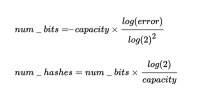

如果我们希望以0.05%的误报率存储50000个对象（不管对象本身有多大）（也就是说，在我们说我们以前见过对象的次数中，有0.05%的时候，我们实际上没有见过），则需要791015位存储和11个哈希函数。

为了进一步提高内存使用效率，我们可以使用单个位来表示bool值（本地bool实际上需要4位）。我们可以通过使用bitarray模块轻松地做到这一点。下面例子显示了一个简单的Bloom过滤器实现。

例：简单的Bloom过滤器实现

In [ ]:
import math

import bitarray
import mmh3


class BloomFilter:
    def __init__(self, capacity, error=0.005):
        """
        Initialize a Bloom filter with given capacity and false positive rate
        """
        self.capacity = capacity
        self.error = error
        self.num_bits = int((-capacity * math.log(error)) // math.log(2) ** 2 + 1)
        self.num_hashes = int((self.num_bits * math.log(2)) // capacity + 1)
        self.data = bitarray.bitarray(self.num_bits)

    def _indexes(self, key):
        h1, h2 = mmh3.hash64(key)
        for i in range(self.num_hashes):
            yield (h1 + i * h2) % self.num_bits

    def add(self, key):
        for index in self._indexes(key):
            self.data[index] = True

    def __contains__(self, key):
        return all(self.data[index] for index in self._indexes(key))

    def __len__(self):
        bit_off_num = self.data.count(True)
        bit_off_percent = 1.0 - bit_off_num / self.num_bits
        length = -1.0 * self.num_bits * math.log(bit_off_percent) / self.num_hashes
        return int(length)

    @staticmethod
    def union(bloom_a, bloom_b):
        assert bloom_a.capacity == bloom_b.capacity, "Capacities must be equal"
        assert bloom_a.error == bloom_b.error, "Error rates must be equal"

        bloom_union = BloomFilter(bloom_a.capacity, bloom_a.error)
        bloom_union.data = bloom_a.data | bloom_b.data
        return bloom_union

如果我们插入的项目比我们为Bloom过滤器的容量指定的多，会发生什么情况？在极端情况下，bool列表中的所有项都将设置为True，在这种情况下，我们说我们已经看到了所有项。这意味着Bloom过滤器对其初始容量的设置非常敏感，如果我们处理的是一组大小未知的数据（例如，一个数据流），这可能会非常严重。

处理这种情况的一种方法是使用一种称为可伸缩Bloom过滤器的Bloom过滤器变体。7它们通过将错误率以特定方式变化的多个Bloom过滤器链接在一起来工作。通过这样做，我们可以保证总体错误率，并在需要更多容量时添加新的Bloom过滤器。为了检查我们以前是否看到过一个项目，我们迭代所有的子Blooms，直到找到对象或者耗尽列表。这个结构的一个示例实现可以在下面示例中看到，我们使用以前的Bloom过滤器实现底层功能，并且有一个计数器来简化何时添加新Bloom的知道。

例：简单缩放Bloom过滤器实现

In [ ]:
from bloomfilter import BloomFilter

class ScalingBloomFilter:
    def __init__(self, capacity, error=0.005, max_fill=0.8,
                 error_tightening_ratio=0.5):
        self.capacity = capacity
        self.base_error = error
        self.max_fill = max_fill
        self.items_until_scale = int(capacity * max_fill)
        self.error_tightening_ratio = error_tightening_ratio
        self.bloom_filters = []
        self.current_bloom = None
        self._add_bloom()

    def _add_bloom(self):
        new_error = self.base_error * self.error_tightening_ratio ** len(
            self.bloom_filters
        )
        new_bloom = BloomFilter(self.capacity, new_error)
        self.bloom_filters.append(new_bloom)
        self.current_bloom = new_bloom
        return new_bloom

    def add(self, key):
        if key in self:
            return True
        self.current_bloom.add(key)
        self.items_until_scale -= 1
        if self.items_until_scale == 0:
            bloom_size = len(self.current_bloom)
            bloom_max_capacity = int(self.current_bloom.capacity * self.max_fill)

            # We may have been adding many duplicate values into the Bloom, so
            # we need to check if we actually need to scale or if we still have
            # space
            if bloom_size >= bloom_max_capacity:
                self._add_bloom()
                self.items_until_scale = bloom_max_capacity
            else:
                self.items_until_scale = int(bloom_max_capacity - bloom_size)
        return False

    def __contains__(self, key):
        return any(key in bloom for bloom in self.bloom_filters)

    def __len__(self):
        return int(sum(len(bloom) for bloom in self.bloom_filters))

另一种处理方法是使用一种称为定时布鲁姆过滤器的方法。此变体允许元素从数据结构中过期，从而为更多元素释放空间。这对于处理流特别好，因为我们可以让元素在一小时后过期，并将容量设置为足以处理我们每小时看到的数据量。用这种方式使用布卢姆过滤器可以让我们很好地了解过去一个小时发生的事情。

使用这个数据结构就像使用一个set对象。在下面的交互中，我们使用scalable Bloom filter添加几个对象，测试之前是否见过它们，然后尝试通过实验找到假阳性率：

In [ ]:
bloom = BloomFilter(100)

In [ ]:
for i in range(50):
   ....:     bloom.add(str(i))
   ....:

In [ ]:
"20" in bloom

In [ ]:
"25" in bloom

In [ ]:
"51" in bloom

In [ ]:
num_false_positives = 0

In [ ]:
num_true_negatives = 0

In [ ]:
# None of the following numbers should be in the Bloom.

In [ ]:
# If one is found in the Bloom, it is a false positive.

In [ ]:
for i in range(51,10000):
   ....:     if str(i) in bloom:
   ....:         num_false_positives += 1
   ....:     else:
   ....:         num_true_negatives += 1
   ....:

In [ ]:
num_false_positives

In [ ]:
num_true_negatives

In [ ]:
false_positive_rate = num_false_positives / float(10000 - 51)

In [ ]:
false_positive_rate

In [ ]:
bloom.error

我们还可以使用Bloom过滤器进行联合，以连接多个项目集：

bloom_a = BloomFilter(200)

In [ ]:
bloom_b = BloomFilter(200)

In [ ]:
for i in range(50):
   ...:     bloom_a.add(str(i))
   ...:

In [ ]:
for i in range(25,75):
   ...:     bloom_b.add(str(i))
   ...:

In [ ]:
bloom = BloomFilter.union(bloom_a, bloom_b)

In [ ]:
"51" in bloom_a

In [ ]:
"24" in bloom_b

In [ ]:
"25" in bloom

一个警告是，你可以采取联合只有两个开花相同的能力和错误率。此外，最终大方坯的使用容量可以高达两个大方坯联合使用的容量之和。这意味着您可以从两个略超过半满的Bloom过滤器开始，当您将它们结合在一起时，得到一个容量过大且不可靠的新Bloom！

## LogLog Counter

LogLog类型计数器基于这样一种实现：散列函数的各个位也可以被认为是随机的。也就是说，散列的第一位为1的概率为50%，前两位为01的概率为25%，前三位为001的概率为12.5%。知道了这些概率，并将哈希值保持在0的最开头（即，最不可能的哈希值），我们就可以估计出到目前为止我们已经看到了多少项。

这种方法的一个很好的类比就是抛硬币。想象一下，我们想把一枚硬币抛32次，每次都能得到人头。数字32来自这样一个事实：我们使用的是32位哈希函数。如果我们掷硬币一次，它就出现了尾巴，我们将存储数字0，因为我们的最佳尝试产生了0头在一行。既然我们知道掷硬币背后的概率，我们还可以告诉你，我们最长的系列是0长的，你可以估计我们已经尝试了这个实验2^0=1次。如果我们不停地掷硬币，在得到一条尾巴之前，我们能得到10个头像，那么我们就会把数字10储存起来。使用同样的逻辑，你可以估计我们已经尝试了实验2^10=1024次。在这个系统中，我们所能计算的最大翻转次数是我们考虑的最大翻转次数（对于32次翻转，这是2^32=4294967296）。

为了用LogLog类型的计数器对这个逻辑进行编码，我们取输入的哈希值的二进制表示，在看到第一个1之前，先看看有多少个0。散列值可以被认为是一系列的32个硬币翻转，其中0表示正面翻转，1表示反面翻转（即，000010101101表示我们在第一个尾部之前翻转了四个头部，010101101表示我们在翻转第一个尾部之前翻转了一个头部）。这让我们知道在达到这个散列值之前发生了多少次尝试。这个系统背后的数学几乎等同于莫里斯计数器，只有一个主要的例外：我们通过查看实际输入而不是使用随机数生成器来获取“随机”值。这意味着如果我们不断地向LogLog计数器添加相同的值，它的内部状态就不会改变。下面例子显示了一个日志计数器的简单实现。

例：LogLog register的简单实现

In [ ]:
import mmh3

def trailing_zeros(number):
    """
    Returns the index of the first bit set to 1 from the right side of a 32-bit
    integer
    >>> trailing_zeros(0)
    32
    >>> trailing_zeros(0b1000)
    3
    >>> trailing_zeros(0b10000000)
    7
    """
    if not number:
        return 32
    index = 0
    while (number >> index) & 1 == 0:
        index += 1
    return index

class LogLogRegister:
    counter = 0
    def add(self, item):
        item_hash = mmh3.hash(str(item))
        return self._add(item_hash)

    def _add(self, item_hash):
        bit_index = trailing_zeros(item_hash)
        if bit_index > self.counter:
            self.counter = bit_index

    def __len__(self):
        return 2**self.counter

这种方法的最大缺点是，我们可能会得到一个哈希值，该值在开始时增加计数器，并使我们的估计发生偏差。这将类似于在第一次尝试时翻转32条尾巴。为了解决这个问题，我们应该让许多人同时掷硬币，并结合他们的结果。大数定律告诉我们，当我们添加越来越多的鳍状肢时，总统计数据受个别鳍状肢异常样本的影响会越来越小。我们组合结果的确切方式是LogLog类型方法（经典LogLog、SuperLogLog、HyperLogLog、HyperLogLog++）之间差异的根源。

我们可以通过获取散列值的前几位并使用它来指定哪个翻转器具有特定的结果来完成这个“多翻转器”方法。如果我们取散列的前4位，这意味着我们有2^4=16个翻转器。由于我们使用了前4位进行选择，所以只剩下28位（对应于每个硬币翻转器的28个单独硬币翻转），这意味着每个计数器最多只能计数2^28=268435456。此外，还有一个常数（alpha）取决于翻转器的数量，它使估计标准化。9所有这些共同为我们提供了一个精确的算法，其中m是使用的寄存器（或翻转器）的数量。下面例子展示了LogLog算法的简单实现。

例：LogLog的简单实现

In [ ]:
import mmh3

from llregister import LLRegister

class LL:
    def __init__(self, p):
        self.p = p
        self.num_registers = 2 ** p
        self.registers = [LLRegister() for i in range(int(2 ** p))]
        self.alpha = 0.7213 / (1.0 + 1.079 / self.num_registers)

    def add(self, item):
        item_hash = mmh3.hash(str(item))
        register_index = item_hash & (self.num_registers - 1)
        register_hash = item_hash >> self.p
        self.registers[register_index]._add(register_hash)

    def __len__(self):
        register_sum = sum(h.counter for h in self.registers)
        length = (self.num_registers * self.alpha *
                  2 ** (register_sum / self.num_registers))
        return int(length)

除了此算法通过使用哈希值作为指示符来消除类似项的重复之外，它还有一个可调参数，可用于拨号您愿意做出的任何精度与存储折衷。

在uuu len_uuuu方法中，我们平均所有单个日志寄存器的估计值。然而，这并不是组合数据的最有效方法！这是因为我们可能会得到一些不幸的散列值，使一个特定寄存器的峰值上升，而其他寄存器的值仍然很低。正因为如此，我们能够实现的错误率只有，其中m是使用的寄存器数。

SuperLogLog是为了解决这个问题而设计的。10在这个算法中，只有最低70%的寄存器用于大小估计，它们的值受到限制规则给出的最大值的限制。这个加法将错误率降低到。这是违反直觉的，因为我们通过忽略信息得到了更好的估计！

最后，HyperLogLog在2007年问世，并为我们提供了进一步的精度提升。11它通过改变单个寄存器的平均方法实现了这一点：我们使用了一种球形平均方案，而不仅仅是平均，该方案还特别考虑了结构可能处于的不同边缘情况。这就得出了当前的最佳错误率。此外，此公式删除了SuperLogLog所需的排序操作。当您试图以大容量插入项时，这可以极大地提高数据结构的性能。下面例子显示了HyperLogLog的基本实现。

例：HyperLogLog的简单实现

In [ ]:
import math

from ll import LL

class HyperLogLog(LL):
    def __len__(self):
        indicator = sum(2 ** -m.counter for m in self.registers)
        E = self.alpha * (self.num_registers ** 2) / indicator

        if E <= 5.0 / 2.0 * self.num_registers:
            V = sum(1 for m in self.registers if m.counter == 0)
            if V != 0:
                Estar = (self.num_registers *
                         math.log(self.num_registers / (1.0 * V), 2))

            else:
                Estar = E
        else:
            if E <= 2 ** 32 / 30.0:
                Estar = E
            else:
                Estar = -2 ** 32 * math.log(1 - E / 2 ** 32, 2)
        return int(Estar)

if __name__ == "__main__":
    import mmh3

    hll = HyperLogLog(8)
    for i in range(100000):
        hll.add(mmh3.hash(str(i)))
    print(len(hll))

## 现实世界的例子

为了更好地理解数据结构，我们首先创建一个具有许多唯一键的数据集，然后创建一个具有重复项的数据集。下面图显示了当我们将这些键输入到我们刚刚查看的数据结构中并定期查询“有多少个唯一的条目？”时的结果，我们可以看到包含更多有状态变量的数据结构（如HyperLogLog和KMinValues）做得更好，因为他们更能处理糟糕的统计数据。另一方面，如果出现一个不幸的随机数或散列值，Morris计数器和单个LogLog寄存器可能会很快产生很高的错误率。然而，对于大多数算法，我们知道有状态变量的数量与错误保证直接相关，因此这是有意义的。

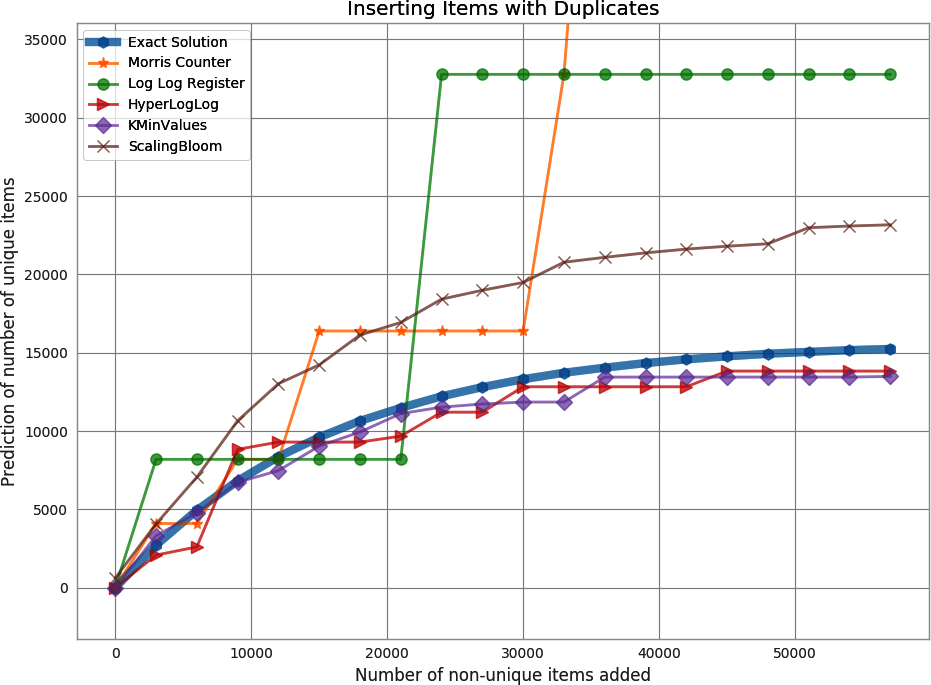

图11-9。使用多个概率数据结构的重复数据的近似计数。为此，我们生成了60000个包含许多重复项的项，并将它们插入到各种概率数据结构中。图表化是对过程中唯一项目数量的结构预测。

看看性能最好的概率数据结构（实际上是您可能会使用的），我们可以总结一下它们的实用性和大致的内存使用情况（见表） 11-2). 根据我们关心的问题，我们可以看到内存使用的巨大变化。这只是强调了一个事实，即在使用概率数据结构时，在继续之前，必须首先考虑关于数据集您真正需要回答的问题。还要注意的是，只有布卢姆过滤器的大小取决于元素的数量。HyperLogLog和KMinValues结构的大小仅取决于错误率。

作为另一个更现实的测试，我们选择使用来自维基百科文本的数据集。我们运行了一个非常简单的脚本，以便从所有文章中提取具有五个或更多字符的所有单字标记，并将它们存储在一个换行分隔的文件中。然后的问题是，“有多少独特的代币？”结果可以在下面表中看到.

表：主要概率数据结构及其集合运算的比较

<table id="memory_pd_comparison">
<caption><span class="label">Table 11-2. </span>Comparison of major probabilistic data structures and the set operations available on them</caption>
<thead>
<tr>
<th></th>
<th>Size</th>
<th>Union<sup><a data-type="noteref" id="idm46122397003048-marker" href="ch11.xhtml#idm46122397003048">a</a></sup></th>
<th>Intersection</th>
<th>Contains</th>
<th>Size<sup><a data-type="noteref" id="idm46122397001176-marker" href="ch11.xhtml#idm46122397001176">b</a></sup></th>
</tr>
</thead>
<tbody>
<tr>
<td><p>HyperLogLog</p></td>
<td><p>Yes (<span class="MathJax_Preview"></span><span class="MathJax_SVG" id="MathJax-Element-12-Frame" role="textbox" aria-readonly="true" style="display: inline-block;"><svg xmlns:xlink="http://www.w3.org/1999/xlink" viewBox="0 -1819.09177 4952.3629120000005 3138.18354" style="width: 11.502ex; height: 7.289ex; vertical-align: -3.096ex; margin: 1px 0px;"><g stroke="black" fill="black" stroke-thickness="0" transform="matrix(1 0 0 -1 0 0)"><use xlink:href="#MJMATHI-4F"></use><g transform="translate(768,1819)"><use xlink:href="#MJSZ4-239B" x="0" y="-1165"></use><use xlink:href="#MJSZ4-239D" x="0" y="-2485"></use></g><g transform="translate(1768,0)"><rect stroke="none" width="2184" height="60" x="0" y="220"></rect><g transform="translate(60,615)"><use transform="scale(1.148144)" xlink:href="#MJMAIN-31"></use><use transform="scale(1.148144)" xlink:href="#MJMAIN-2E" x="505" y="0"></use><g transform="translate(904,0)"><use transform="scale(1.148144)" xlink:href="#MJMAIN-30"></use><use transform="scale(1.148144)" xlink:href="#MJMAIN-34" x="505" y="0"></use></g></g><g transform="translate(104,-943)"><use transform="scale(1.148144)" xlink:href="#MJMAIN-221A" x="0" y="-118"></use><rect stroke="none" width="1013" height="68" x="962" y="725"></rect><use transform="scale(1.148144)" xlink:href="#MJMATHI-6D" x="838" y="0"></use></g></g><g transform="translate(4072,1819)"><use xlink:href="#MJSZ4-239E" x="0" y="-1164"></use><use xlink:href="#MJSZ4-23A0" x="0" y="-2485"></use></g></g></svg></span><script type="math/mml" id="MathJax-Element-12"><math xmlns="http://www.w3.org/1998/Math/MathML" alttext="upper O left-parenthesis StartFraction 1.04 Over StartRoot m EndRoot EndFraction right-parenthesis">
  <mrow>
    <mi>O</mi>
    <mo>(</mo>
    <mfrac><mrow><mn>1</mn><mo>.</mo><mn>04</mn></mrow> <msqrt><mi>m</mi></msqrt></mfrac>
    <mo>)</mo>
  </mrow>
</math></script>)</p></td>
<td><p>Yes</p></td>
<td><p>No<sup><a data-type="noteref" id="memory_caveat-marker" href="ch11.xhtml#memory_caveat">c</a></sup></p></td>
<td><p>No</p></td>
<td><p>2.704 MB</p></td>
</tr>
<tr>
<td><p>KMinValues</p></td>
<td><p>Yes (<span class="MathJax_Preview"></span><span class="MathJax_SVG" id="MathJax-Element-13-Frame" role="textbox" aria-readonly="true" style="display: inline-block;"><svg xmlns:xlink="http://www.w3.org/1999/xlink" viewBox="0 -1999.3785480000001 7833.985328000001 3498.7570960000003" style="width: 18.195ex; height: 8.126ex; vertical-align: -3.515ex; margin: 1px 0px;"><g stroke="black" fill="black" stroke-thickness="0" transform="matrix(1 0 0 -1 0 0)"><use xlink:href="#MJMATHI-4F"></use><g transform="translate(768,1999)"><use xlink:href="#MJSZ4-239B" x="0" y="-1165"></use><use xlink:href="#MJSZ4-239D" x="0" y="-2845"></use></g><g transform="translate(1648,0)"><use xlink:href="#MJSZ4-221A" x="0" y="-240"></use><rect stroke="none" width="4300" height="60" x="1005" y="1460"></rect><g transform="translate(1005,0)"><rect stroke="none" width="4180" height="60" x="0" y="220"></rect><use transform="scale(1.148144)" xlink:href="#MJMAIN-32" x="1568" y="514"></use><g transform="translate(60,-952)"><use transform="scale(1.148144)" xlink:href="#MJMATHI-3C0"></use><use transform="scale(1.148144)" xlink:href="#MJMAIN-28" x="578" y="0"></use><use transform="scale(1.148144)" xlink:href="#MJMATHI-6D" x="972" y="0"></use><use transform="scale(1.148144)" xlink:href="#MJMAIN-2212" x="1855" y="0"></use><use transform="scale(1.148144)" xlink:href="#MJMAIN-32" x="2638" y="0"></use><use transform="scale(1.148144)" xlink:href="#MJMAIN-29" x="3143" y="0"></use></g></g></g><g transform="translate(6953,1999)"><use xlink:href="#MJSZ4-239E" x="0" y="-1164"></use><use xlink:href="#MJSZ4-23A0" x="0" y="-2845"></use></g></g></svg></span><script type="math/mml" id="MathJax-Element-13"><math xmlns="http://www.w3.org/1998/Math/MathML" alttext="upper O left-parenthesis StartRoot StartFraction 2 Over pi left-parenthesis m minus 2 right-parenthesis EndFraction EndRoot right-parenthesis">
  <mrow>
    <mi>O</mi>
    <mo>(</mo>
    <msqrt>
      <mfrac><mn>2</mn> <mrow><mi>π</mi><mo>(</mo><mi>m</mi><mo>-</mo><mn>2</mn><mo>)</mo></mrow></mfrac>
    </msqrt>
    <mo>)</mo>
  </mrow>
</math></script>)</p></td>
<td><p>Yes</p></td>
<td><p>Yes</p></td>
<td><p>No</p></td>
<td><p>20.372 MB</p></td>
</tr>
<tr>
<td><p>Bloom filter</p></td>
<td><p>Yes (<span class="MathJax_Preview"></span><span class="MathJax_SVG" id="MathJax-Element-14-Frame" role="textbox" aria-readonly="true" style="display: inline-block;"><svg xmlns:xlink="http://www.w3.org/1999/xlink" viewBox="0 -1819.09177 4952.3629120000005 3138.18354" style="width: 11.502ex; height: 7.289ex; vertical-align: -3.096ex; margin: 1px 0px;"><g stroke="black" fill="black" stroke-thickness="0" transform="matrix(1 0 0 -1 0 0)"><use xlink:href="#MJMATHI-4F"></use><g transform="translate(768,1819)"><use xlink:href="#MJSZ4-239B" x="0" y="-1165"></use><use xlink:href="#MJSZ4-239D" x="0" y="-2485"></use></g><g transform="translate(1768,0)"><rect stroke="none" width="2184" height="60" x="0" y="220"></rect><g transform="translate(60,615)"><use transform="scale(1.148144)" xlink:href="#MJMAIN-30"></use><use transform="scale(1.148144)" xlink:href="#MJMAIN-2E" x="505" y="0"></use><g transform="translate(904,0)"><use transform="scale(1.148144)" xlink:href="#MJMAIN-37"></use><use transform="scale(1.148144)" xlink:href="#MJMAIN-38" x="505" y="0"></use></g></g><g transform="translate(104,-943)"><use transform="scale(1.148144)" xlink:href="#MJMAIN-221A" x="0" y="-118"></use><rect stroke="none" width="1013" height="68" x="962" y="725"></rect><use transform="scale(1.148144)" xlink:href="#MJMATHI-6D" x="838" y="0"></use></g></g><g transform="translate(4072,1819)"><use xlink:href="#MJSZ4-239E" x="0" y="-1164"></use><use xlink:href="#MJSZ4-23A0" x="0" y="-2485"></use></g></g></svg></span><script type="math/mml" id="MathJax-Element-14"><math xmlns="http://www.w3.org/1998/Math/MathML" alttext="upper O left-parenthesis StartFraction 0.78 Over StartRoot m EndRoot EndFraction right-parenthesis">
  <mrow>
    <mi>O</mi>
    <mo>(</mo>
    <mfrac><mrow><mn>0</mn><mo>.</mo><mn>78</mn></mrow> <msqrt><mi>m</mi></msqrt></mfrac>
    <mo>)</mo>
  </mrow>
</math></script>)</p></td>
<td><p>Yes</p></td>
<td><p>No<sup><a data-type="noteref" href="ch11.xhtml#memory_caveat">c</a></sup></p></td>
<td><p>Yes</p></td>
<td><p>197.8 MB</p></td>
</tr>
</tbody>
<tbody><tr class="footnotes"><td colspan="6"><p data-type="footnote" id="idm46122397003048"><sup><a href="ch11.xhtml#idm46122397003048-marker">a</a></sup> Union operations occur without increasing the error rate.</p><p data-type="footnote" id="idm46122397001176"><sup><a href="ch11.xhtml#idm46122397001176-marker">b</a></sup> Size of data structure with 0.05% error rate, 100 million unique elements, and using a 64-bit hashing function.</p><p data-type="footnote" id="memory_caveat"><sup><a href="ch11.xhtml#memory_caveat-marker">c</a></sup> These operations <em>can</em> be done but at a considerable penalty in terms of accuracy.</p></td></tr></tbody></table>

这个实验的主要收获是，如果你能够专门化你的代码，你可以获得惊人的速度和内存增益。整本书都是这样的：当我们将代码专门化为“选择性优化：找到需要修复的内容”时，我们同样能够提高速度。

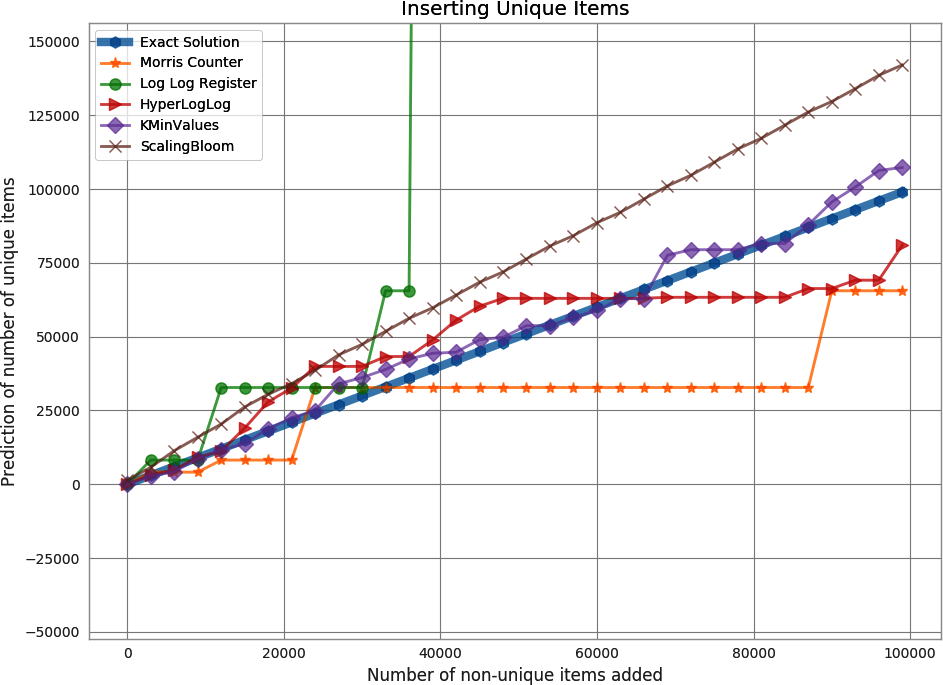

图 使用多个概率数据结构的唯一数据的近似计数。为此，我们将数字1到100000插入到数据结构中。图表化是对过程中唯一项目数量的结构预测。

概率数据结构是一种专门化代码的算法方法。我们只存储所需的数据，以便在给定的误差范围内回答特定的问题。通过只处理给定信息的一个子集，我们不仅可以使内存占用更小，而且可以更快地在结构上执行大多数操作。

<table id="memory_pd_wiki_comparison">
<caption><span class="label">Table 11-3. </span>Size estimates for the number of unique words in Wikipedia</caption>
<thead>
<tr>
<th></th>
<th>Elements</th>
<th>Relative error</th>
<th>Processing time<sup><a data-type="noteref" id="idm46122396962408-marker" href="ch11.xhtml#idm46122396962408">a</a></sup></th>
<th>Structure size<sup><a data-type="noteref" id="idm46122396961256-marker" href="ch11.xhtml#idm46122396961256">b</a></sup></th>
</tr>
</thead>
<tbody>
<tr>
<td><p>Morris counter<sup><a data-type="noteref" id="idm46122396958776-marker" href="ch11.xhtml#idm46122396958776">c</a></sup></p></td>
<td><p>1,073,741,824</p></td>
<td><p>6.52%</p></td>
<td><p>751s</p></td>
<td><p>5 bits</p></td>
</tr>
<tr>
<td><p>LogLog register</p></td>
<td><p>1,048,576</p></td>
<td><p>78.84%</p></td>
<td><p>1,690s</p></td>
<td><p>5 bits</p></td>
</tr>
<tr>
<td><p>LogLog</p></td>
<td><p>4,522,232</p></td>
<td><p>8.76%</p></td>
<td><p>2,112s</p></td>
<td><p>5 bits</p></td>
</tr>
<tr>
<td><p>HyperLogLog</p></td>
<td><p>4,983,171</p></td>
<td><p>–0.54%</p></td>
<td><p>2,907s</p></td>
<td><p>40 KB</p></td>
</tr>
<tr>
<td><p>KMinValues</p></td>
<td><p>4,912,818</p></td>
<td><p>0.88%</p></td>
<td><p>3,503s</p></td>
<td><p>256 KB</p></td>
</tr>
<tr>
<td><p>Scaling Bloom</p></td>
<td><p>4,949,358</p></td>
<td><p>0.14%</p></td>
<td><p>10,392s</p></td>
<td><p>11,509 KB</p></td>
</tr>
<tr>
<td><p>True value</p></td>
<td><p>4,956,262</p></td>
<td><p>0.00%</p></td>
<td><p>-----</p></td>
<td><p>49,558 KB<sup><a data-type="noteref" id="idm46122396935256-marker" href="ch11.xhtml#idm46122396935256">d</a></sup></p></td>
</tr>
</tbody>
<tbody><tr class="footnotes"><td colspan="5"><p data-type="footnote" id="idm46122396962408"><sup><a href="ch11.xhtml#idm46122396962408-marker">a</a></sup> Processing time has been adjusted to remove the time to read the dataset from disk. We also use the simple implementations provided earlier for testing.</p><p data-type="footnote" id="idm46122396961256"><sup><a href="ch11.xhtml#idm46122396961256-marker">b</a></sup> Structure size is theoretical given the amount of data since the implementations used were not optimized.</p><p data-type="footnote" id="idm46122396958776"><sup><a href="ch11.xhtml#idm46122396958776-marker">c</a></sup> Since the Morris counter doesn’t deduplicate input, the size and relative error are given with regard to the total number of values.</p><p data-type="footnote" id="idm46122396935256"><sup><a href="ch11.xhtml#idm46122396935256-marker">d</a></sup> The dataset is 49,558 KB considering only unique tokens, or 8.742 GB with all tokens.</p></td></tr></tbody></table>

因此，无论您是否使用概率数据结构，您都应该始终记住您将要对数据提出哪些问题，以及如何最有效地存储这些数据以提出这些专门问题。这可能归结为使用一种特定类型的列表而不是另一种，使用一种特定类型的数据库索引而不是另一种，甚至可能使用概率数据结构来抛出除相关数据以外的所有数据！